## Setting Up the Libs and Seam Arid Configurations

In [2]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import deepwave
from deepwave import elastic
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 10                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = [20,20]                  # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 180                   # model shape of z dimension (depth) Seam Arid
ny        = 400                   # model shape of y dimension Seam Arid
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 20                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 199        # number of receivers per shot
source_spacing = np.floor(dx[0] * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx[0] * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 2 * dx[0]               # the index depth of sources, default is 0
receiver_depth = 2 * dx[0]             # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [10,10,0,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lrp            = 30        # learning rate for updating the model.
fwi_lrs            = 10        # learning rate for updating the model.
fwi_lrrho            = 2        # learning rate for updating the model.

fwi_batch         =   num_shots      # number of batches for FWI.
fwi_num_epochs    = 200       # number of FWI iteration.
sim_lr            = 1*1e-5   # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations

d_source = np.floor( dx[0]*(ny / (num_shots+1)) )    # 20 * 4m = 80m
first_source = 25*dx[0]  # 10 * 4m = 40m

d_receiver = np.floor( dx[0]*(ny / (num_receivers_per_shot)) )    # 6 * 4m = 24m
first_receiver = 1*dx[0]  # 0 * 4m = 0m


##   Check Cuda Device 


In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes and Observed Data

In [5]:
from scipy.ndimage import gaussian_filter

fwi_result = 'results/' + 'Seam_Arid_lrp=' + str(fwi_lrp) + '_lrs' + str(fwi_lrs) + '_lrrho' + str(fwi_lrrho) + '_lrsiamese=' + str(sim_lr) + '_fwi_num_epochs=' + str(fwi_num_epochs) + '+ '/'

# Check if the directory exists
if not os.path.exists(fwi_result):
    # If not, create the directory
    os.makedirs(fwi_result)
    print(f"Directory '{fwi_result}' created.")
else:
    print(f"Directory '{fwi_result}' already exists.")
    
    
model_true_vp = torch.from_numpy(np.load('data/vp_arid_shallow.npy').reshape(400,180)).float().to(device).T
model_true_vs = torch.from_numpy(np.load('data/vs_arid_shallow.npy').reshape(400,180)).float().to(device).T
model_true_rho = torch.from_numpy(np.load('data/rho_arid_shallow.npy').reshape(400,180)).float().to(device).T




# Shift the value range
model_true_vp = denormalize_vp(normalize_vp(model_true_vp, vmin=model_true_vp.min(), vmax=model_true_vp.max()))
model_true_vs = denormalize_vs(normalize_vs(model_true_vs, vmin=model_true_vs.min(), vmax=model_true_vs.max()))
model_true_rho = denormalize_rho(normalize_rho(model_true_rho, vmin=model_true_rho.min(), vmax=model_true_rho.max()))

print(model_true_vp.shape)

# Mask water column
mask = torch.ones_like(model_true_vp).to(device)

# Smoothed initial model
model_vp = torch.from_numpy(gaussian_filter(model_true_vp.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_vs = torch.from_numpy(gaussian_filter(model_true_vs.detach().cpu().numpy(), sigma=[15,30])).to(device)
model_rho = torch.from_numpy(gaussian_filter(model_true_rho.detach().cpu().numpy(), sigma=[15,30])).to(device)




# Loading the true model
model_init_vp = model_vp
# The model will be updated during FWI
model_vp = torch.nn.Parameter(model_vp)

# Loading the true model
model_init_vs = model_vs
# The model will be updated during FWI
model_vs = torch.nn.Parameter(model_vs)

# Loading the true model
model_init_rho = model_rho
# The model will be updated during FWI
model_rho = torch.nn.Parameter(model_rho)


# x_s
x_s = torch.zeros(num_shots, num_sources_per_shot, 2,
                               dtype=torch.long, device=device)
x_s[..., 1] = source_depth
x_s[:, 0, 0] = (torch.arange(num_shots) * d_source +
                             first_source)

# x_r
x_r = torch.zeros(num_shots, num_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
x_r[..., 1] = receiver_depth
x_r[:, :, 0] = (
    (torch.arange(num_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(num_shots, 1)
)

#dx1 = 4*dx
x_s = torch.floor(x_s/dx[0]) 
x_r = torch.floor(x_r/dx[0]) 

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(peak_freq, nt, dt, peak_source_time)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)

source = source_amplitudes

# Create observed data using true models
receiver_amplitudes_true = elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(model_true_vp.T, model_true_vs.T,
                                               model_true_rho.T),
    dx, dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=x_s,
    receiver_locations_y=x_r,
    accuracy=4,
    pml_width=pml_width,
    pml_freq=peak_freq)[-2]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

Directory 'results/Seam_Arid_lrp=30_lrs10_lrrho2_lrsiamese=1e-05_fwi_num_epochs=200' created.
torch.Size([180, 400])


torch.Size([20, 199, 2000])

# Plotting the Shot Gather

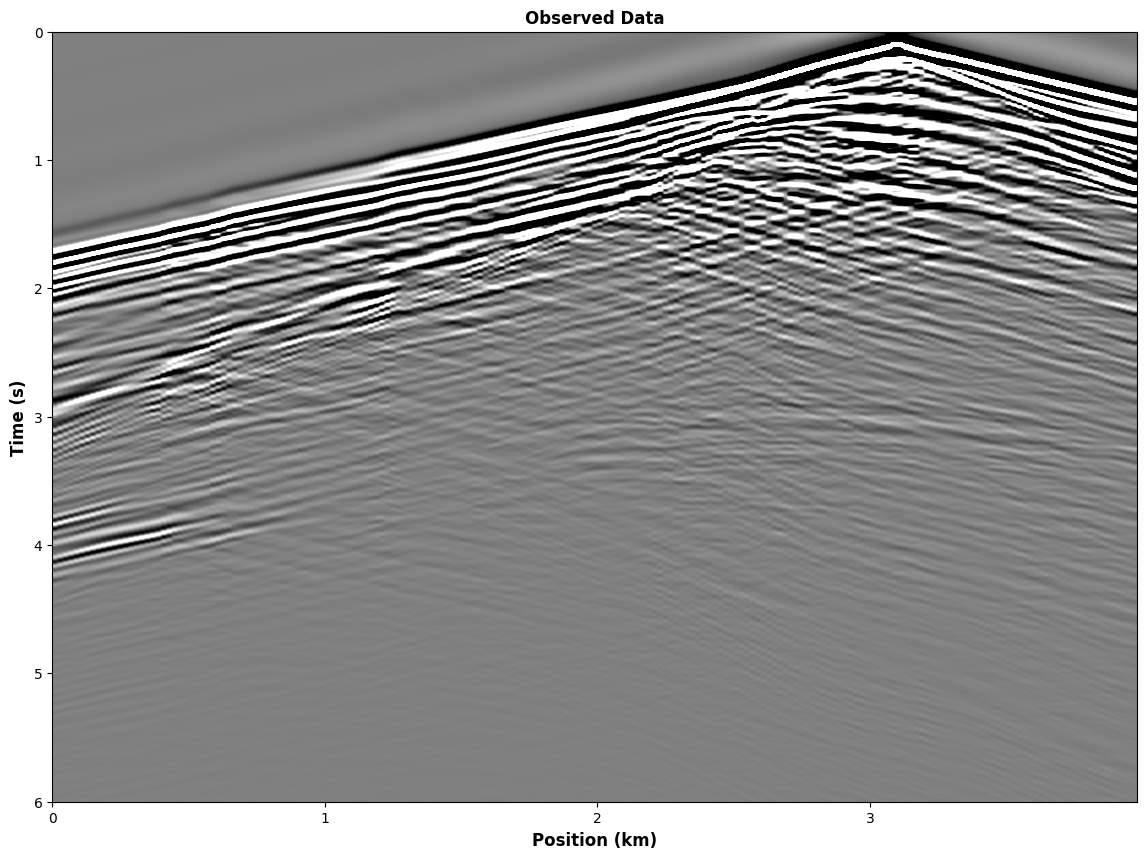

In [6]:
#plt.imshow(batch_rcv_amps_true[:,0,:].detach().cpu().numpy(),aspect='auto',cmap='gray')
#batch_rcv_amps_true[:,0,:].shape


%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

selected_shot = rcv_amps_true[15,:,:].T
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx[1]/1000, selected_shot.shape[0] *(dt), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
#ax.text(0, -0.15, 'a)', fontsize = 12) 
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xticklabels([])
plt.show()
#f.savefig('Observed_Combined.png', bbox_inches='tight',transparent=True, dpi =100)


## Plotting the inital and true model


(3000.0, 2887.0, 1732.0, 2887.0, 2294.0, 2607.0)

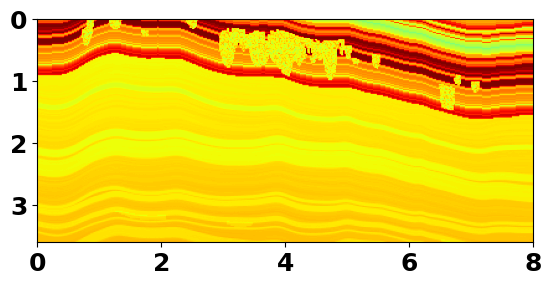

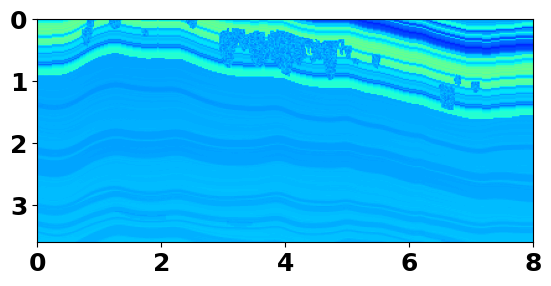

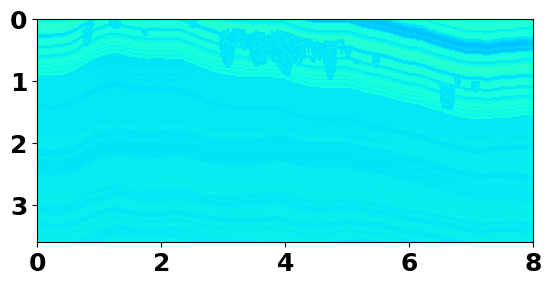

In [7]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4800

plt.rc('font', **font)


modelp = model_true_vp.detach().cpu().numpy()
im = plt.imshow(modelp, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelp.shape[1] * dx[1] / 1000, modelp.shape[0] * dx[0] / 1000, 0])

plt.figure()
models = model_true_vs.detach().cpu().numpy()
im = plt.imshow(models, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, models.shape[1] * dx[1] / 1000, models.shape[0] * dx[0] / 1000, 0])

plt.figure()
modelrho = model_true_rho.detach().cpu().numpy()
im = plt.imshow(modelrho, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelrho.shape[1] * dx[1] / 1000, modelrho.shape[0] * dx[0] / 1000, 0])

modelp.min(),models.max(), models.min(),models.max(), modelrho.min(), modelrho.max()

(3539.2947, 2563.3599, 2208.5112, 2563.3599, 2432.1787, 2510.3835)

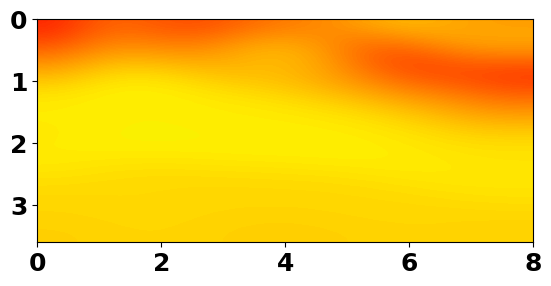

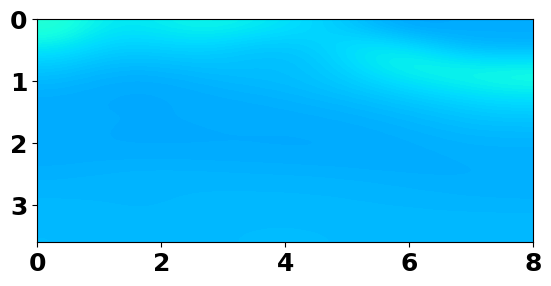

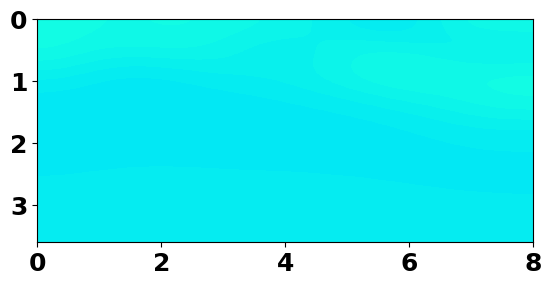

In [8]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4800

plt.rc('font', **font)


modelp = model_vp.detach().cpu().numpy()
im = plt.imshow(modelp, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelp.shape[1] * dx[1] / 1000, modelp.shape[0] * dx[0] / 1000, 0])

plt.figure()
models = model_vs.detach().cpu().numpy()
im = plt.imshow(models, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, models.shape[1] * dx[1] / 1000, models.shape[0] * dx[0] / 1000, 0])

plt.figure()
modelrho = model_rho.detach().cpu().numpy()
im = plt.imshow(modelrho, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modelrho.shape[1] * dx[1] / 1000, modelrho.shape[0] * dx[0] / 1000, 0])

modelp.min(),models.max(), models.min(),models.max(), modelrho.min(), modelrho.max()

## Setting Up the Siamese and Optimizers

In [9]:
from torchsummary import summary
from Model.Module22_644 import *
import  torch

# Min/Max Vel
box_min1 = model_true_vp.min()
box_max1 = model_true_vp.max()
box_min2 = model_true_vs.min()
box_max2 = model_true_vs.max()
box_min3 = model_true_rho.min()
box_max3 = model_true_rho.max()

#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizerp = optim.Adam([{'params': model_vp, 'lr':fwi_lrp, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizers = optim.Adam([{'params': model_vs, 'lr':fwi_lrs, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])
optimizerrho = optim.Adam([{'params': model_rho, 'lr':fwi_lrrho, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

optimizer = torch.optim.LBFGS([model_vp,model_vs,model_rho])
#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

schedulerp = torch.optim.lr_scheduler.MultiplicativeLR(optimizerp, lr_lambda=lr_lambda)
schedulers = torch.optim.lr_scheduler.MultiplicativeLR(optimizers, lr_lambda=lr_lambda)
schedulerrho = torch.optim.lr_scheduler.MultiplicativeLR(optimizerrho, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(4,nt,num_receivers_per_shot),(4,nt,num_receivers_per_shot)])


############## Init  ################# 
SNRP = 0.0
SSIMP = 0.0
LossP = 0.0
SNRS = 0.0
SSIMS = 0.0
LossS = 0.0
SNRrho = 0.0
SSIMrho = 0.0
Loss = 0.0
ERRORP = 0.0
ERRORS = 0.0
ERRORrho = 0.0




Number of netD params: 5432
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 4, 2000, 199]             148
         LeakyReLU-2         [-1, 4, 2000, 199]               0
            Conv2d-3         [-1, 4, 2000, 199]             148
         LeakyReLU-4         [-1, 4, 2000, 199]               0
            Conv2d-5         [-1, 8, 2000, 199]             296
         LeakyReLU-6         [-1, 8, 2000, 199]               0
            Conv2d-7        [-1, 16, 2000, 199]             592
         LeakyReLU-8        [-1, 16, 2000, 199]               0
            Conv2d-9         [-1, 8, 2000, 199]             296
        LeakyReLU-10         [-1, 8, 2000, 199]               0
           Conv2d-11         [-1, 4, 2000, 199]             148
        LeakyReLU-12         [-1, 4, 2000, 199]               0
           Conv2d-13         [-1, 4, 2000, 199]             148
        Lea

## Main ElasticSiameseFWI

In [10]:
import ptwt
import pywt
import torch.nn.functional as F
# Starting the FWI loop.
global model_vp, model_vs, model_rho, source_amplitudes_init, SNRP, SSIMP, Loss, ERRORS, SNRS, SSIMS, ERRORS, SNRrho, SSIMrho, ERRORrho



# Scaling factor
ma = 1/rcv_amps_true.max().detach().cpu().numpy()
con = 10*ma

t_start = time.time()
#model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizerps to zero grad.
        optimizerp.zero_grad()
        optimizers.zero_grad()
        optimizerrho.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        #prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
        #                                  order,survey_pad)
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = elastic( *deepwave.common.vpvsrho_to_lambmubuoyancy(model_vp.T, model_vs.T,
                                        model_rho.T),
                                        dx, dt,
                                        source_amplitudes_y=batch_src_amps,
                                        source_locations_y=batch_x_s,
                                        receiver_locations_y=batch_x_r,
                                        accuracy=4,
                                        pml_width=pml_width,
                                        pml_freq=peak_freq)[-2]

        batch_rcv_amps_true = con*batch_rcv_amps_true[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_true.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_real = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)

        
        batch_rcv_amps_pred = con*batch_rcv_amps_pred[0,:,:]
        coefficients = ptwt.wavedec2(batch_rcv_amps_pred.T, pywt.Wavelet("haar"),
                                     level=2, mode="zero")
        d_fake = torch.cat((coefficients[0][0,:,:].unsqueeze(0),coefficients[1][0][0,:,:].unsqueeze(0),coefficients[1][1][0,:,:].unsqueeze(0),coefficients[1][2][0,:,:].unsqueeze(0)),dim=0).unsqueeze(0)


        # Siamese Network
        disc_fake, disc_real, o1, o2 = netD(d_real,d_fake)
        # normalized Loss Function
        loss1 = F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ 0.3*F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1[0,3,:,:],o2[0,3,:,:], keepdim = True).mean()
        observed_l2_norm = torch.norm(batch_rcv_amps_true, p=2)
        loss = loss1/observed_l2_norm
        

        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        torch.nn.utils.clip_grad_value_(model_vs,1e3) 
        torch.nn.utils.clip_grad_value_(model_rho,1e3) 

        # Update the velocity model
        optimizerp.step()
        optimizers.step()
        optimizerrho.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12)
        model_vs.data=torch.clamp(model_vs.data,min=1e-12)
        model_rho.data=torch.clamp(model_rho.data,min=1e-12)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%100==0):
        schedulerp.step()
        schedulers.step()
        schedulerrho.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizerp.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    #P model
    snrP = ComputeSNR(model_vp.detach().cpu().numpy(),  
              model_true_vp.detach().cpu().numpy())
    SNRP = np.append(SNRP, snrP)

    ssimP = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              model_true_vp.detach().cpu().numpy())
    SSIMP = np.append(SSIMP, ssimP)

    rerrorP = ComputeRE(model_vp.detach().cpu().numpy(), \
              model_true_vp.detach().cpu().numpy())
    ERRORP = np.append(ERRORP, rerrorP)
    
    # S Model
    snrS = ComputeSNR(model_vs.detach().cpu().numpy(),  
              model_true_vs.detach().cpu().numpy())
    SNRS = np.append(SNRS, snrS)

    ssimS = ComputeSSIM(model_vs.detach().cpu().numpy(), \
              model_true_vs.detach().cpu().numpy())
    SSIMS = np.append(SSIMS, ssimS)

    rerrorS = ComputeRE(model_vs.detach().cpu().numpy(), \
              model_true_vs.detach().cpu().numpy())
    ERRORS = np.append(ERRORS, rerrorS)
    
    # Rho model
    snrrho = ComputeSNR(model_rho.detach().cpu().numpy(),  
              model_true_rho.detach().cpu().numpy())
    SNRrho = np.append(SNRrho, snrrho)

    ssimrho = ComputeSSIM(model_rho.detach().cpu().numpy(), \
              model_true_rho.detach().cpu().numpy())
    SSIMrho = np.append(SSIMrho, ssimrho)

    rerrorrho = ComputeRE(model_rho.detach().cpu().numpy(), \
              model_true_rho.detach().cpu().numpy())
    ERRORrho = np.append(ERRORrho, rerrorrho)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR_P:', snrP, 'SSIM_P:', ssimP.cpu().detach().cpu().numpy(), 'SNR_S:', snrS, 'SSIM_S:', ssimS.cpu().detach().cpu().numpy(),  'SNR_rho:', snrrho, 'SSIM_rho:', ssimrho.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERecP_.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESERecS_.mat', \
                         {'rec':model_vs.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESERecrho_.mat', \
                         {'rec':model_rho.cpu().data.numpy()}) 
        
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNRP':SNRP,'SSIMP':SSIMP, \
                          'Loss':Loss,'ERRORP':ERRORP,
                         'SNRS':SNRS,'SSIMS':SSIMS, 'ERRORS':ERRORS, 'SNRrho':SNRrho,'SSIMrho':SSIMrho,'ERRORrho':ERRORrho}) 
  
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snrP,ssimP,rerrorP)), fmt='%5.4f') 



Epoch: 1 Loss:  0.010834843665361405 lr_DL: 1e-05 lr_vel: 30 SNR_P: 23.11686885642082 SSIM_P: 0.20255955 SNR_S: 24.284730965469215 SSIM_S: 0.3343822 SNR_rho: 36.07421235620344 SSIM_rho: 0.5713951
Epoch: 2 Loss:  0.008775075036101043 lr_DL: 1e-05 lr_vel: 30 SNR_P: 23.22433858625552 SSIM_P: 0.20434262 SNR_S: 24.38745779876633 SSIM_S: 0.34149826 SNR_rho: 36.092414244086285 SSIM_rho: 0.57390547
Epoch: 3 Loss:  0.007699784752912819 lr_DL: 1e-05 lr_vel: 30 SNR_P: 23.32817903053931 SSIM_P: 0.20626536 SNR_S: 24.50620231342146 SSIM_S: 0.34707168 SNR_rho: 36.10668850136215 SSIM_rho: 0.5743153
Epoch: 4 Loss:  0.006821358785964548 lr_DL: 1e-05 lr_vel: 30 SNR_P: 23.43979019830677 SSIM_P: 0.20859572 SNR_S: 24.624831386887962 SSIM_S: 0.35297793 SNR_rho: 36.12087889408641 SSIM_rho: 0.5732973
Epoch: 5 Loss:  0.006075794110074639 lr_DL: 1e-05 lr_vel: 30 SNR_P: 23.557710445309098 SSIM_P: 0.21120307 SNR_S: 24.74304551670638 SSIM_S: 0.3588783 SNR_rho: 36.137126272524675 SSIM_rho: 0.5718603
Epoch: 6 Loss:  

Epoch: 43 Loss:  0.0015920025354716927 lr_DL: 1e-05 lr_vel: 30 SNR_P: 25.815436863657993 SSIM_P: 0.30985174 SNR_S: 27.983209628976418 SSIM_S: 0.52923673 SNR_rho: 36.85234219867761 SSIM_rho: 0.5977183
Epoch: 44 Loss:  0.0015820085885934533 lr_DL: 1e-05 lr_vel: 30 SNR_P: 25.84716075165767 SSIM_P: 0.31236783 SNR_S: 28.042150434640753 SSIM_S: 0.5332767 SNR_rho: 36.867473866249895 SSIM_rho: 0.59890765
Epoch: 45 Loss:  0.0015573425742331892 lr_DL: 1e-05 lr_vel: 30 SNR_P: 25.877307764453953 SSIM_P: 0.31435025 SNR_S: 28.09832012507187 SSIM_S: 0.53400636 SNR_rho: 36.88000384858606 SSIM_rho: 0.5992278
Epoch: 46 Loss:  0.0015275601064786315 lr_DL: 1e-05 lr_vel: 30 SNR_P: 25.90844078654403 SSIM_P: 0.31669495 SNR_S: 28.155386240204237 SSIM_S: 0.53814375 SNR_rho: 36.895258756135355 SSIM_rho: 0.6004103
Epoch: 47 Loss:  0.001503913413034752 lr_DL: 1e-05 lr_vel: 30 SNR_P: 25.937565302471146 SSIM_P: 0.31882784 SNR_S: 28.20923183315533 SSIM_S: 0.53830975 SNR_rho: 36.90773648690418 SSIM_rho: 0.60070705
Ep

Epoch: 85 Loss:  0.0011444276227848605 lr_DL: 1e-05 lr_vel: 30 SNR_P: 26.782976717846108 SSIM_P: 0.38160208 SNR_S: 29.74216190831749 SSIM_S: 0.59219587 SNR_rho: 37.411942105867524 SSIM_rho: 0.6304191
Epoch: 86 Loss:  0.0011313043622067198 lr_DL: 1e-05 lr_vel: 30 SNR_P: 26.801227587402018 SSIM_P: 0.38271746 SNR_S: 29.775742277023276 SSIM_S: 0.5940297 SNR_rho: 37.42408360941651 SSIM_rho: 0.63100475
Epoch: 87 Loss:  0.001141672339872457 lr_DL: 1e-05 lr_vel: 30 SNR_P: 26.815453326420307 SSIM_P: 0.3840919 SNR_S: 29.80204759405535 SSIM_S: 0.5944428 SNR_rho: 37.43435822271574 SSIM_rho: 0.63180524
Epoch: 88 Loss:  0.0011244945373618976 lr_DL: 1e-05 lr_vel: 30 SNR_P: 26.833640785599435 SSIM_P: 0.38507012 SNR_S: 29.83391513753093 SSIM_S: 0.5954754 SNR_rho: 37.447718381435 SSIM_rho: 0.63275
Epoch: 89 Loss:  0.0011158235283801332 lr_DL: 1e-05 lr_vel: 30 SNR_P: 26.849391665906346 SSIM_P: 0.38644454 SNR_S: 29.863569176284784 SSIM_S: 0.5962645 SNR_rho: 37.45666735179827 SSIM_rho: 0.6330699
Epoch: 90 

Epoch: 126 Loss:  0.0007427270582411438 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.27121560066535 SSIM_P: 0.41795638 SNR_S: 30.640014676732182 SSIM_S: 0.6259785 SNR_rho: 37.76832525616247 SSIM_rho: 0.65593505
Epoch: 127 Loss:  0.0007459236978320405 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.28094189072805 SSIM_P: 0.41853514 SNR_S: 30.656436666171224 SSIM_S: 0.6264098 SNR_rho: 37.77331695858603 SSIM_rho: 0.6558822
Epoch: 128 Loss:  0.0007416529231704771 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.288373072474087 SSIM_P: 0.41918066 SNR_S: 30.67172842463945 SSIM_S: 0.6270782 SNR_rho: 37.78149312556281 SSIM_rho: 0.65705824
Epoch: 129 Loss:  0.000737472967011854 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.298028333570596 SSIM_P: 0.41990095 SNR_S: 30.68818632785277 SSIM_S: 0.62750816 SNR_rho: 37.786464329355326 SSIM_rho: 0.6568589
Epoch: 130 Loss:  0.0007357519818469882 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.30529864023508 SSIM_P: 0.4204925 SNR_S: 30.703109621452427 SSIM_S: 0.62826324 SNR_rho: 37.794545265701494 SSIM_rho: 0

Epoch: 167 Loss:  0.0006409916939446702 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.59482918309604 SSIM_P: 0.442167 SNR_S: 31.22576323771903 SSIM_S: 0.64534026 SNR_rho: 38.01531725184435 SSIM_rho: 0.67291
Epoch: 168 Loss:  0.0006371608789777384 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.602603325504013 SSIM_P: 0.44269076 SNR_S: 31.23896284384277 SSIM_S: 0.6458047 SNR_rho: 38.02172483103786 SSIM_rho: 0.67357594
Epoch: 169 Loss:  0.0006397477904101833 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.60914267358244 SSIM_P: 0.44325218 SNR_S: 31.25103356729094 SSIM_S: 0.6462139 SNR_rho: 38.02593567930311 SSIM_rho: 0.673892
Epoch: 170 Loss:  0.0006315961276413873 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.61646577665555 SSIM_P: 0.4437093 SNR_S: 31.26352647413404 SSIM_S: 0.6465792 SNR_rho: 38.03257080928046 SSIM_rho: 0.67419434
Epoch: 171 Loss:  0.0006320032087387517 lr_DL: 1e-05 lr_vel: 15.0 SNR_P: 27.623883868108166 SSIM_P: 0.44431266 SNR_S: 31.276125253929358 SSIM_S: 0.64695895 SNR_rho: 38.03659656774108 SSIM_rho: 0.6745332

In [ ]:
import numpy as np
import glob
import scipy.io
from matplotlib.ticker import MaxNLocator

from utils.utils import *





import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4, 5])




f, ax = plt.subplots(3,3,figsize=(20, 12))
plt.rc('font', **font)


# Min/Max Vel
box_min1 = model_true_vp.min()
box_max1 = model_true_vp.max()
box_min2 = model_true_vs.min()
box_max2 = model_true_vs.max()
box_min3 = model_true_rho.min()
box_max3 = model_true_rho.max()

im = ax[0,0].imshow(model_true_vp.detach().cpu().numpy(), cmap='jet', vmin=box_min1, vmax=box_max1, 
                extent=[0, model_true_vp.shape[1] * dx / 1000, model_true_vp.shape[0] * dx / 1000, 0])

#ax[0,0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0,0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0,0].set_title('True_Model (Vp)',fontsize='large', fontweight='bold')
#ax[0,0].text(0, -0.15, 'a)', fontsize = 22) 
#ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0,0].set_yticks(np.arange(y.min(), y.max(), 1)) 


init_V = model_init_vp
im0 = ax[0,1].imshow(init_V.detach().cpu().numpy(), cmap='jet', vmin=box_min1, vmax=box_max1, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
#ax[0,1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[0,1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0,1].set_title('Initial_Model (Vp)',fontsize='large', fontweight='bold')
#ax[0,1].text(0, -0.15, 'b)', fontsize = 22) 
#ax[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0,1].set_yticks(np.arange(y.min(), y.max(), 1)) 

Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecP_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[0,2].imshow(Siamese_Vel, cmap='jet', vmin=box_min1, vmax=box_max1, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
#ax[0,2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[0,2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0,2].set_title('Siamese (Vp)',fontsize='large', fontweight='bold')
ax[0,2].text(0, -0.15, 'c)', fontsize = 22) 
#ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0,2].set_yticks(np.arange(y.min(), y.max(), 1)) 



im = ax[1,0].imshow(model_true_vs.detach().cpu().numpy(), cmap='jet', vmin=box_min2, vmax=box_max2, 
                extent=[0, model_true_vs.shape[1] * dx / 1000, model_true_vs.shape[0] * dx / 1000, 0])

#ax[1,0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1,0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1,0].set_title('True_Model (Vs)',fontsize='large', fontweight='bold')
ax[1,0].text(0, -0.15, 'e)', fontsize = 22) 
#ax[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1,0].set_yticks(np.arange(y.min(), y.max(), 1)) 


init_V = model_init_vs
im = ax[1,1].imshow(init_V.detach().cpu().numpy(), cmap='jet', vmin=box_min2, vmax=box_max2, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
#ax[1,1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[1,1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1,1].set_title('Initial_Model (Vs)',fontsize='large', fontweight='bold')
#ax[1,1].text(0, -0.15, 'f)', fontsize = 22) 
#ax[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1,1].set_yticks(np.arange(y.min(), y.max(), 1)) 

Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecS_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[1,2].imshow(Siamese_Vel, cmap='jet', vmin=box_min2, vmax=box_max2, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
#ax[1,2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[1,2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1,2].set_title('Siamese (Vs)',fontsize='large', fontweight='bold')
#ax[1,2].text(0, -0.15, 'g)', fontsize = 22) 
#ax[1,2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1,2].set_yticks(np.arange(y.min(), y.max(), 1)) 


im = ax[2,0].imshow(model_true_rho.detach().cpu().numpy(), cmap='jet', vmin=box_min3, vmax=box_max3, 
                extent=[0, model_true_rho.shape[1] * dx / 1000, model_true_rho.shape[0] * dx / 1000, 0])

ax[2,0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2,0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2,0].set_title('True_Model (Rho)',fontsize='large', fontweight='bold')
#ax[2,0].text(0, -0.15, 'i)', fontsize = 22) 
#ax[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2,0].set_yticks(np.arange(y.min(), y.max(), 1)) 


init_V = model_init_rho
im = ax[2,1].imshow(init_V.detach().cpu().numpy(), cmap='jet', vmin=box_min3, vmax=box_max3, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
ax[2,1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[2,1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2,1].set_title('Initial_Model (Rho)',fontsize='large', fontweight='bold')
#ax[2,1].text(0, -0.15, 'j)', fontsize = 22) 
#ax[2,1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2,1].set_yticks(np.arange(y.min(), y.max(), 1)) 

Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERecrho_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2,2].imshow(Siamese_Vel, cmap='jet', vmin=box_min3, vmax=box_max3, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
ax[2,2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
#ax[2,2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2,2].set_title('Siamese (Rho)',fontsize='large', fontweight='bold')
#ax[2,2].text(0, -0.15, 'k)', fontsize = 22) 
#ax[2,2].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[2,2].set_yticks(np.arange(y.min(), y.max(), 1)) 



ax[0,1].set_yticklabels([])
ax[0,2].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[2,2].set_yticklabels([])

ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,2].set_xticklabels([])


ax[1,0].set_xticklabels([])
ax[1,1].set_xticklabels([])
ax[1,2].set_xticklabels([])

cbar_ax = f.add_axes([0.91, 0.15, 0.01, 0.7])
f.colorbar(im0, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

#f.set_figheight(15)
#f.set_figwidth(15)

#plt.colorbar(im, fraction=0.005, pad=0.04)

plt.show()

#f.savefig('Final_Comparsion_PWT_Overthrust_Euc_MultiSources.png', bbox_inches='tight',transparent=True, dpi =100)


## Plotting the Reconstructed Velocity Model

In [18]:
# Saving Network Parameters for Seam Arid
torch.save(netD.state_dict(), fwi_result + 'netD')
netD = torch.load(fwi_result + 'netD')

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'